# Deep Neural Network for Image Classification: Application

When you finish this, you will have finished the last programming assignment of Week 4, and also the last programming assignment of this course! 

You will use use the functions you'd implemented in the previous assignment to build a deep network, and apply it to cat vs non-cat classification. Hopefully, you will see an improvement in accuracy relative to your previous logistic regression implementation.  

**After this assignment you will be able to:**
- Build and apply a deep neural network to supervised learning. 

Let's get started!

## 1 - Packages

Let's first import all the packages that you will need during this assignment. 
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.
- dnn_app_utils provides the functions implemented in the "Building your Deep Neural Network: Step by Step" assignment to this notebook.
- np.random.seed(1) is used to keep all the random function calls consistent. It will help us grade your work.

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## 2 - Dataset

You will use the same "Cat vs non-Cat" dataset as in "Logistic Regression as a Neural Network" (Assignment 2). The model you had built had 70% test accuracy on classifying cats vs non-cats images. Hopefully, your new model will perform a better!

**Problem Statement**: You are given a dataset ("data.h5") containing:
    - a training set of m_train images labelled as cat (1) or non-cat (0)
    - a test set of m_test images labelled as cat and non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB).

Let's get more familiar with the dataset. Load the data by running the cell below.

In [2]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

The following code will show you an image in the dataset. Feel free to change the index and re-run the cell multiple times to see other images. 

y = 0. It's a non-cat picture.


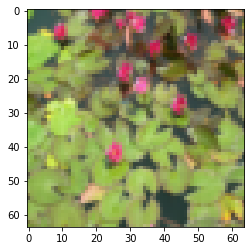

In [3]:
# Example of a picture
index = 18
plt.imshow(train_x_orig[index])

print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")


In [4]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


As usual, you reshape and standardize the images before feeding them to the network. The code is given in the cell below.

<img src="images/imvectorkiank.png" style="width:450px;height:300px;">

<caption><center> <u>Figure 1</u>: Image to vector conversion. <br> </center></caption>

In [5]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


$12,288$ equals $64 \times 64 \times 3$ which is the size of one reshaped image vector.

## 3 - Architecture of your model

Now that you are familiar with the dataset, it is time to build a deep neural network to distinguish cat images from non-cat images.

You will build two different models:
- A 2-layer neural network
- An L-layer deep neural network

You will then compare the performance of these models, and also try out different values for $L$. 

Let's look at the two architectures.

### 3.1 - 2-layer neural network

<img src="images/2layerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 2</u>: 2-layer neural network. <br> The model can be summarized as: ***INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT***. </center></caption>

<u>Detailed Architecture of figure 2</u>:
- The input is a (64,64,3) image which is flattened to a vector of size $(12288,1)$. 
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ of size $(n^{[1]}, 12288)$.
- You then add a bias term and take its relu to get the following vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- You then repeat the same process.
- You multiply the resulting vector by $W^{[2]}$ and add your intercept (bias). 
- Finally, you take the sigmoid of the result. If it is greater than 0.5, you classify it to be a cat.

### 3.2 - L-layer deep neural network

It is hard to represent an L-layer deep neural network with the above representation. However, here is a simplified network representation:

<img src="images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 3</u>: L-layer neural network. <br> The model can be summarized as: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption>

<u>Detailed Architecture of figure 3</u>:
- The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then you add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, you take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, you take the sigmoid of the final linear unit. If it is greater than 0.5, you classify it to be a cat.

### 3.3 - General methodology

As usual you will follow the Deep Learning methodology to build the model:
    1. Initialize parameters / Define hyperparameters
    2. Loop for num_iterations:
        a. Forward propagation
        b. Compute cost function
        c. Backward propagation
        d. Update parameters (using parameters, and grads from backprop) 
    4. Use trained parameters to predict labels

Let's now implement those two models!

## 4 - Two-layer neural network

**Question**:  Use the helper functions you have implemented in the previous assignment to build a 2-layer neural network with the following structure: *LINEAR -> RELU -> LINEAR -> SIGMOID*. The functions you may need and their inputs are:
```python
def initialize_parameters(n_x, n_h, n_y):
    ...
    return parameters 
def linear_activation_forward(A_prev, W, b, activation):
    ...
    return A, cache
def compute_cost(AL, Y):
    ...
    return cost
def linear_activation_backward(dA, cache, activation):
    ...
    return dA_prev, dW, db
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [6]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [7]:
# GRADED FUNCTION: two_layer_model

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    ### START CODE HERE ### (≈ 1 line of code)
    parameters = initialize_parameters(n_x, n_h, n_y)
    ### END CODE HERE ###
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        ### START CODE HERE ### (≈ 2 lines of code)
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
        ### END CODE HERE ###
        
        # Compute cost
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(A2, Y)
        ### END CODE HERE ###
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        ### START CODE HERE ### (≈ 2 lines of code)
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")
        ### END CODE HERE ###
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        ### START CODE HERE ### (approx. 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Run the cell below to train your parameters. See if your model runs. The cost should be decreasing. It may take up to 5 minutes to run 2500 iterations. Check if the "Cost after iteration 0" matches the expected output below, if not click on the square (⬛) on the upper bar of the notebook to stop the cell and try to find your error.

Cost after iteration 0: 0.6930497356599888
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912677
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605747
Cost after iteration 500: 0.515830477276473
Cost after iteration 600: 0.4754901313943325
Cost after iteration 700: 0.4339163151225749
Cost after iteration 800: 0.4007977536203887
Cost after iteration 900: 0.3580705011323798
Cost after iteration 1000: 0.3394281538366412
Cost after iteration 1100: 0.3052753636196264
Cost after iteration 1200: 0.27491377282130164
Cost after iteration 1300: 0.24681768210614846
Cost after iteration 1400: 0.19850735037466116
Cost after iteration 1500: 0.1744831811255664
Cost after iteration 1600: 0.17080762978096148
Cost after iteration 1700: 0.11306524562164734
Cost after iteration 1800: 0.09629426845937152
Cost after iteration 1900: 0.08342617959726863
Cost after iteration 2000: 0.07439078704319081
Cost after iteration 2100: 0.0663074813

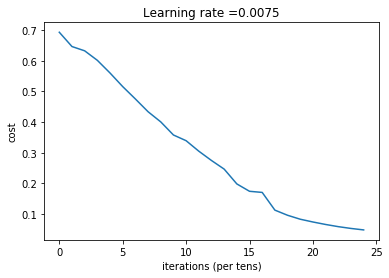

In [8]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

**Expected Output**:
<table> 
    <tr>
        <td> **Cost after iteration 0**</td>
        <td> 0.6930497356599888 </td>
    </tr>
    <tr>
        <td> **Cost after iteration 100**</td>
        <td> 0.6464320953428849 </td>
    </tr>
    <tr>
        <td> **...**</td>
        <td> ... </td>
    </tr>
    <tr>
        <td> **Cost after iteration 2400**</td>
        <td> 0.048554785628770206 </td>
    </tr>
</table>

Good thing you built a vectorized implementation! Otherwise it might have taken 10 times longer to train this.

Now, you can use the trained parameters to classify images from the dataset. To see your predictions on the training and test sets, run the cell below.

In [9]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


**Expected Output**:
<table> 
    <tr>
        <td> **Accuracy**</td>
        <td> 1.0 </td>
    </tr>
</table>

In [10]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.72


**Expected Output**:

<table> 
    <tr>
        <td> **Accuracy**</td>
        <td> 0.72 </td>
    </tr>
</table>

**Note**: You may notice that running the model on fewer iterations (say 1500) gives better accuracy on the test set. This is called "early stopping" and we will talk about it in the next course. Early stopping is a way to prevent overfitting. 

Congratulations! It seems that your 2-layer neural network has better performance (72%) than the logistic regression implementation (70%, assignment week 2). Let's see if you can do even better with an $L$-layer model.

## 5 - L-layer Neural Network

**Question**: Use the helper functions you have implemented previously to build an $L$-layer neural network with the following structure: *[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*. The functions you may need and their inputs are:
```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [11]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [12]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):
        #print('learning rate ', learning_rate, 'iteration ',i)
        print('para ',parameters['W1'][0,0], 'iteration ',i)
        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches = L_model_forward(X, parameters)
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(AL, Y)
        #print('cpst is ',cost)
        ### END CODE HERE ###
        #print('cache length is: ', len(caches))
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL, Y, caches)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

You will now train the model as a 4-layer neural network. 

Run the cell below to train your model. The cost should decrease on every iteration. It may take up to 5 minutes to run 2500 iterations. Check if the "Cost after iteration 0" matches the expected output below, if not click on the square (⬛) on the upper bar of the notebook to stop the cell and try to find your error.

para  0.014653378640123331 iteration  0
Cost after iteration 0: 0.771749
para  0.014486644096030845 iteration  1
para  0.014487774551042656 iteration  2
para  0.014487489289392006 iteration  3
para  0.014487436753285473 iteration  4
para  0.014487384409848415 iteration  5
para  0.014487140393926245 iteration  6
para  0.014486896701844372 iteration  7
para  0.014486628907120314 iteration  8
para  0.014486661253364475 iteration  9
para  0.014486529588618466 iteration  10
para  0.014486398229129172 iteration  11
para  0.014486233726504084 iteration  12
para  0.014486266463657405 iteration  13
para  0.014486102623308192 iteration  14
para  0.014485991924749817 iteration  15
para  0.014485881531293395 iteration  16
para  0.014485588584763816 iteration  17
para  0.014485478882961688 iteration  18
para  0.014485264209612382 iteration  19
para  0.01448521248273748 iteration  20
para  0.014485160802048294 iteration  21
para  0.014485109060395915 iteration  22
para  0.014485057502181268 iteratio

para  0.014633110794004377 iteration  204
para  0.014629537112599504 iteration  205
para  0.014628883150768875 iteration  206
para  0.014629838219406905 iteration  207
para  0.014630526921995452 iteration  208
para  0.014629870972986765 iteration  209
para  0.014633167430420393 iteration  210
para  0.014631626667325103 iteration  211
para  0.0146309727885716 iteration  212
para  0.014633041145247256 iteration  213
para  0.01463372059169146 iteration  214
para  0.01463425088836008 iteration  215
para  0.014637505268250858 iteration  216
para  0.014635512720808895 iteration  217
para  0.014634855573701904 iteration  218
para  0.014636912510208225 iteration  219
para  0.014634835198366909 iteration  220
para  0.01463417308109495 iteration  221
para  0.014636238735448052 iteration  222
para  0.014636232602872556 iteration  223
para  0.014635552280465584 iteration  224
para  0.014637609759913668 iteration  225
para  0.014636438037977506 iteration  226
para  0.014635771640300329 iteration  2

para  0.014707685869240372 iteration  407
para  0.014689538580306739 iteration  408
para  0.014696563467207907 iteration  409
para  0.014708716173134821 iteration  410
para  0.014703579030568098 iteration  411
para  0.01470764620052035 iteration  412
para  0.014695709635930186 iteration  413
para  0.014711126386504528 iteration  414
para  0.014680087654236057 iteration  415
para  0.014686479010975384 iteration  416
para  0.014697428007313693 iteration  417
para  0.014709295641018362 iteration  418
para  0.014684359271092514 iteration  419
para  0.014693883263447706 iteration  420
para  0.014706507516633152 iteration  421
para  0.01468758212225153 iteration  422
para  0.014696452620255146 iteration  423
para  0.014705920545319108 iteration  424
para  0.014704798232351164 iteration  425
para  0.014709127236276206 iteration  426
para  0.014705505736019416 iteration  427
para  0.014707008446085194 iteration  428
para  0.014707584292857791 iteration  429
para  0.014688456705383176 iteration

para  0.014915050449167473 iteration  602
para  0.014925463851844317 iteration  603
para  0.014896053754165823 iteration  604
para  0.014917604351547084 iteration  605
para  0.014889881796820506 iteration  606
para  0.014917894885265934 iteration  607
para  0.01492943189318841 iteration  608
para  0.0148900003645515 iteration  609
para  0.014917143396321586 iteration  610
para  0.0148826788588239 iteration  611
para  0.01491674086645329 iteration  612
para  0.014939391465331511 iteration  613
para  0.014849422058149585 iteration  614
para  0.014873582445161751 iteration  615
para  0.014898434620127663 iteration  616
para  0.01490719560819572 iteration  617
para  0.014934765031572952 iteration  618
para  0.0149102347300508 iteration  619
para  0.01493195814361618 iteration  620
para  0.014881757339594572 iteration  621
para  0.014913895218360833 iteration  622
para  0.014938898875466698 iteration  623
para  0.014907191204879938 iteration  624
para  0.014941325453316903 iteration  625
pa

para  0.01500863038618222 iteration  799
para  0.014993691305964943 iteration  800
Cost after iteration 800: 0.369126
para  0.015022481132578206 iteration  801
para  0.014975946452628374 iteration  802
para  0.015018456127253103 iteration  803
para  0.01501427697213594 iteration  804
para  0.015005237213815964 iteration  805
para  0.015028632477993756 iteration  806
para  0.014975016860265172 iteration  807
para  0.015016179459723696 iteration  808
para  0.015008488160114039 iteration  809
para  0.015023783711814153 iteration  810
para  0.015000836240465804 iteration  811
para  0.015035934606079191 iteration  812
para  0.014971037102629937 iteration  813
para  0.015001058154972373 iteration  814
para  0.01503273135221874 iteration  815
para  0.014983693625321938 iteration  816
para  0.01502789816494759 iteration  817
para  0.01499433968573196 iteration  818
para  0.015025482218509432 iteration  819
para  0.01498512268027201 iteration  820
para  0.015026843084655208 iteration  821
para 

para  0.015250715757964132 iteration  1000
Cost after iteration 1000: 0.315187
para  0.015299135106600976 iteration  1001
para  0.015270481807548426 iteration  1002
para  0.015311558997759949 iteration  1003
para  0.015250107838377014 iteration  1004
para  0.01530292520386279 iteration  1005
para  0.015271841284303367 iteration  1006
para  0.0153132969547014 iteration  1007
para  0.015257837966736458 iteration  1008
para  0.01530419813601615 iteration  1009
para  0.015282057648302755 iteration  1010
para  0.01531654602917258 iteration  1011
para  0.015274785129136865 iteration  1012
para  0.015313982502613495 iteration  1013
para  0.015281409010167953 iteration  1014
para  0.015320903286118464 iteration  1015
para  0.015274980144616188 iteration  1016
para  0.015317256064050152 iteration  1017
para  0.015272489883945573 iteration  1018
para  0.015315460618408858 iteration  1019
para  0.015284231630772077 iteration  1020
para  0.015317042646125888 iteration  1021
para  0.015278870811407

para  0.015647998757024995 iteration  1196
para  0.015685212456737985 iteration  1197
para  0.015655292364626698 iteration  1198
para  0.015693131221902884 iteration  1199
para  0.015643058871105543 iteration  1200
Cost after iteration 1200: 0.237419
para  0.015679766445938402 iteration  1201
para  0.015671476090974957 iteration  1202
para  0.015699357720544777 iteration  1203
para  0.015648492620583803 iteration  1204
para  0.015683509862382972 iteration  1205
para  0.015680989736832376 iteration  1206
para  0.01571295820648957 iteration  1207
para  0.015668312153963953 iteration  1208
para  0.01570513501845586 iteration  1209
para  0.015683262467887888 iteration  1210
para  0.01571844502760743 iteration  1211
para  0.015667689625725963 iteration  1212
para  0.015701838844100948 iteration  1213
para  0.01569427943529329 iteration  1214
para  0.015724807045289294 iteration  1215
para  0.015675686498516132 iteration  1216
para  0.01570915868151352 iteration  1217
para  0.015708284581412

para  0.01604237847918312 iteration  1392
para  0.01607290359914151 iteration  1393
para  0.016072032301335595 iteration  1394
para  0.0161048475476878 iteration  1395
para  0.016051604813338973 iteration  1396
para  0.01608021935098836 iteration  1397
para  0.016081125255845912 iteration  1398
para  0.016108041683018538 iteration  1399
para  0.01606130466489108 iteration  1400
Cost after iteration 1400: 0.189263
para  0.016093892478602923 iteration  1401
para  0.01607860123303712 iteration  1402
para  0.016112450799230304 iteration  1403
para  0.016054260485782117 iteration  1404
para  0.0160867595199724 iteration  1405
para  0.01608621689830712 iteration  1406
para  0.01612002813776343 iteration  1407
para  0.01605235920587354 iteration  1408
para  0.016092012002272008 iteration  1409
para  0.016092112189187515 iteration  1410
para  0.016128144409363884 iteration  1411
para  0.0160463936059352 iteration  1412
para  0.016092928051771857 iteration  1413
para  0.016090337068028635 itera

para  0.01619420379708441 iteration  1583
para  0.016200675880880144 iteration  1584
para  0.01618554173395895 iteration  1585
para  0.01619658403918971 iteration  1586
para  0.01618260502802919 iteration  1587
para  0.016195258027025056 iteration  1588
para  0.01617678065135061 iteration  1589
para  0.016190993519383745 iteration  1590
para  0.016196836728487603 iteration  1591
para  0.016203932897465186 iteration  1592
para  0.01619391178930048 iteration  1593
para  0.01620496671392599 iteration  1594
para  0.016185578901734984 iteration  1595
para  0.01619877596593904 iteration  1596
para  0.016177734349783153 iteration  1597
para  0.016192424979763413 iteration  1598
para  0.016203870855187562 iteration  1599
para  0.016209784989694127 iteration  1600
Cost after iteration 1600: 0.148214
para  0.01620398677263628 iteration  1601
para  0.016205773551816616 iteration  1602
para  0.01620715004976147 iteration  1603
para  0.016206676130115893 iteration  1604
para  0.01621385330711415 it

para  0.016287429994379585 iteration  1775
para  0.016287745884723148 iteration  1776
para  0.01629586672010102 iteration  1777
para  0.01628112578959334 iteration  1778
para  0.016291494366669237 iteration  1779
para  0.016295060441120644 iteration  1780
para  0.016300818270386812 iteration  1781
para  0.016296767874750626 iteration  1782
para  0.016304894856747083 iteration  1783
para  0.016288816241768603 iteration  1784
para  0.01629634913698362 iteration  1785
para  0.016288652320384994 iteration  1786
para  0.016297798387637095 iteration  1787
para  0.016306635837273317 iteration  1788
para  0.016309453794820045 iteration  1789
para  0.016306458345230843 iteration  1790
para  0.01629840761751375 iteration  1791
para  0.016303940508635033 iteration  1792
para  0.016285753013665853 iteration  1793
para  0.01629671008142319 iteration  1794
para  0.016304333389687224 iteration  1795
para  0.016311207339513543 iteration  1796
para  0.016304763628256808 iteration  1797
para  0.01631203

para  0.016409527264439193 iteration  1973
para  0.016415204117903714 iteration  1974
para  0.016420121217431624 iteration  1975
para  0.016396870072061753 iteration  1976
para  0.01640878537106086 iteration  1977
para  0.016414744188147905 iteration  1978
para  0.016409745247795867 iteration  1979
para  0.01641668539733599 iteration  1980
para  0.016424103800942405 iteration  1981
para  0.01642374322314358 iteration  1982
para  0.01641616058310103 iteration  1983
para  0.01642124463210779 iteration  1984
para  0.01640488965545016 iteration  1985
para  0.016413793170801723 iteration  1986
para  0.016423386499988587 iteration  1987
para  0.016420641175664677 iteration  1988
para  0.01642722923102775 iteration  1989
para  0.016413109896400088 iteration  1990
para  0.016421627477015005 iteration  1991
para  0.016428518188911716 iteration  1992
para  0.016436094982495406 iteration  1993
para  0.016428515813028358 iteration  1994
para  0.016436457759180196 iteration  1995
para  0.0164196055

para  0.016548101852291414 iteration  2169
para  0.01653450347254013 iteration  2170
para  0.016540200718236343 iteration  2171
para  0.016543521723199863 iteration  2172
para  0.016547755874789113 iteration  2173
para  0.016536274442701514 iteration  2174
para  0.01654150856676116 iteration  2175
para  0.0165471973935896 iteration  2176
para  0.016542603024724177 iteration  2177
para  0.0165477828846222 iteration  2178
para  0.016547054348323847 iteration  2179
para  0.016551450476041788 iteration  2180
para  0.016548307246896817 iteration  2181
para  0.016555644750619887 iteration  2182
para  0.016542380412401296 iteration  2183
para  0.01654869152465456 iteration  2184
para  0.01655360676282633 iteration  2185
para  0.01655428533012511 iteration  2186
para  0.016559625586167557 iteration  2187
para  0.016539793385115277 iteration  2188
para  0.016548128673185964 iteration  2189
para  0.01655426362718464 iteration  2190
para  0.016557915599659828 iteration  2191
para  0.0165634449215

para  0.016652732643370357 iteration  2361
para  0.016651485787257343 iteration  2362
para  0.016656571751532175 iteration  2363
para  0.016651752254424956 iteration  2364
para  0.016657901176886952 iteration  2365
para  0.016653837051627575 iteration  2366
para  0.016656664920078553 iteration  2367
para  0.016653336346297606 iteration  2368
para  0.01665812807374558 iteration  2369
para  0.016662893172297685 iteration  2370
para  0.016650008286549778 iteration  2371
para  0.016655178982944368 iteration  2372
para  0.016659948697767928 iteration  2373
para  0.016660135891652154 iteration  2374
para  0.01666244806354108 iteration  2375
para  0.01666065042015322 iteration  2376
para  0.016663838060133277 iteration  2377
para  0.016666257540520486 iteration  2378
para  0.01665605947949246 iteration  2379
para  0.016662878028513562 iteration  2380
para  0.016662607214087237 iteration  2381
para  0.016666132731853904 iteration  2382
para  0.016669863012629627 iteration  2383
para  0.0166576

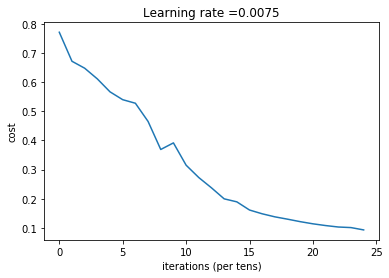

In [13]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

**Expected Output**:
<table> 
    <tr>
        <td> **Cost after iteration 0**</td>
        <td> 0.771749 </td>
    </tr>
    <tr>
        <td> **Cost after iteration 100**</td>
        <td> 0.672053 </td>
    </tr>
    <tr>
        <td> **...**</td>
        <td> ... </td>
    </tr>
    <tr>
        <td> **Cost after iteration 2400**</td>
        <td> 0.092878 </td>
    </tr>
</table>

In [14]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9856459330143539


<table>
    <tr>
    <td>
    **Train Accuracy**
    </td>
    <td>
    0.985645933014
    </td>
    </tr>
</table>

In [15]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8


**Expected Output**:

<table> 
    <tr>
        <td> **Test Accuracy**</td>
        <td> 0.8 </td>
    </tr>
</table>

Congrats! It seems that your 4-layer neural network has better performance (80%) than your 2-layer neural network (72%) on the same test set. 

This is good performance for this task. Nice job! 

Though in the next course on "Improving deep neural networks" you will learn how to obtain even higher accuracy by systematically searching for better hyperparameters (learning_rate, layers_dims, num_iterations, and others you'll also learn in the next course). 

##  6) Results Analysis

First, let's take a look at some images the L-layer model labeled incorrectly. This will show a few mislabeled images. 

In [ ]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

**A few types of images the model tends to do poorly on include:** 
- Cat body in an unusual position
- Cat appears against a background of a similar color
- Unusual cat color and species
- Camera Angle
- Brightness of the picture
- Scale variation (cat is very large or small in image) 

## 7) Test with your own image (optional/ungraded exercise) ##

Congratulations on finishing this assignment. You can use your own image and see the output of your model. To do that:
    1. Click on "File" in the upper bar of this notebook, then click "Open" to go on your Coursera Hub.
    2. Add your image to this Jupyter Notebook's directory, in the "images" folder
    3. Change your image's name in the following code
    4. Run the code and check if the algorithm is right (1 = cat, 0 = non-cat)!

In [ ]:
## START CODE HERE ##
my_image = "my_image.jpg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)
## END CODE HERE ##

fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((num_px*num_px*3,1))
my_image = my_image/255.
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

**References**:

- for auto-reloading external module: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython